# ElasticSearch DSL

Librería de alto nivel que ayuda a escribir y ejecutar consultas en Elastic.
Proporciona una API más idiomática y pythonica para manipular y componer consultas.
Proporciona una capa para trabajar con los documentos, definiendo el mapping, rescatar, actualizar, guardar documentos,  usando orientación a objetos.

### Conexión con nuestro cluster.

Tenemos una forma cómoda de conectarnos, tan solo indicando una lista de dominios o ips, de los nodos de nuestro cluster. Permite configurar muchas opciones de la capa de transporte, incluidos certificados ssl.

In [1]:
from elasticsearch_dsl import connections

connections.create_connection(hosts=['elasticsearch'])

<Elasticsearch([{'host': 'elasticsearch'}])>

La api de Elasticsearch DSL, permite comprobar el estado de nuestro cluster.

In [32]:
# Consultamos el estado de nuestro cluster, (red, yellow, green).
connections.get_connection().cluster.health()['status']

'yellow'

### Uso de Mapping

De forma opcional, podemos definir un mapping elasticsearch, desde una clase python. Esto tiene multiples ventajas.

1. Fijar nosotros mismos la naturaleza de la información que vamos a almacenar en el indice.
2. Trabajar con los documentos de este indice, haciendo uso de los atributos y los métodos de la clase,
pudiendo hacer programación orientada a objetos.
3. Definir nosotros mismos el "analyzer" que se debe aplicar.
4. Definir de forma programática, opciones de la configuración del índice.


En este caso usamos el analizador "snowball", para ver más [https://snowballstem.org/](https://snowballstem.org/). 
Para conocer todos los [built_in_analyzers](https://www.elastic.co/guide/en/elasticsearch/guide/master/analysis-intro.html#_built_in_analyzers) podemos consultar la referencia.

In [4]:
from datetime import datetime
from elasticsearch_dsl import Document, Date, Integer, Keyword, Text
from elasticsearch_dsl.connections import connections


class Article(Document):
    title = Text(analyzer='snowball', fields={'raw': Keyword()})
    body = Text(analyzer='snowball')
    tags = Keyword()
    published_from = Date()
    words = Integer()
    url = Keyword()

    class Index:
        name = 'blog'
        settings = {
          "number_of_shards": 2,
        }

    def save(self, ** kwargs):
        self.words = len(self.body.split())
        return super(Article, self).save(** kwargs)

    def is_published(self):
        return datetime.now() >= self.published_from

In [6]:
import elasticsearch.exceptions as elasticexceptions
from elasticsearch_dsl import Index

# Instanciar un objeto referente al índice.
index = Index("blog")

try:
    # En caso de existir previamente, obligamos a borrarlo.
    index.delete()
except elasticexceptions.NotFoundError:
    pass

# Ejecutamos la creación del índice, con el mapping definido.
Article.init()

Una vez creado el indice, ya podemos empezar a crear documentos.

Creamos manualmente una serie de objetos de tipo de Articulo.

In [26]:
article1 = Article(title='Docketiza tu aplicación', tags=['devops', 'virtualizacion', 'docker'])
article1.body = '''Hoy día quizá escuches frecuentemente términos como Devops, Virtualización y por supuesto Cloud. En las siguientes lineas hablaremos sobre ellas y además para hacer la cosa más divertida  presentar una aplicación real de todos estos conceptos.Virtualización es un concepto muy amplio y tiene diferentes aplicaciones según el nivel donde se dé, ya hemos hablado en otra ocasión de Copicloud, donde la virtualización llega al extremo, convirtiéndose en un “cloud”.Hoy nos centraremos en otro nivel de virtualización, destinado tanto a desarrolladores como a administradores de sistemas, es por ello que os presento la herramienta Docker. Por ser actualmente una de las herramientas preferidas en el mundillo Devops. '''
article1.published_from = datetime.now()
article1.url = "http://blog.intelligenia.com/2016/06/docketiza-tu-aplicacion.html"
article1.save()

article2 = Article(title='Consumiendo websocket desde el bar', tags=['websocket', 'http', 'services'])
article2.body = ''' No podemos negar que Internet está creciendo, tanto en número de usuario, como en número de servicios que ofrece, así como en número de dispositivos que están conectados. Esto hace que las necesidades también sean mayores y las aplicaciones se adapten a cada una de ellas.Hoy día, estamos acostumbrados a trabajar con aplicaciones cada vez más dinámicas. Donde el proceso de comunicación sea cada vez más transparente al usuario, de forma que no se perciba el constante diálogo con el servidor web. Estamos cada vez más familiarizados con aplicaciones que nos muestran información en tiempo real, ya sea el estado de la bolsa o el tiempo meteorológico de nuestra zona, aplicaciones que nos muestran notificaciones y se actualiza nuestra bandeja de correo electrónico, así como chats donde podemos conversar con otros usuarios.Una tecnología reciente que permite tener una comunicación bidireccional y persistente entre nuestras aplicaciones web y el servidor web, recibe el nombre de Websocket.'''
article2.published_from = datetime.now()
article1.url = "http://blog.intelligenia.com/2016/12/consumiendo-websocket-desde-el-bar.html"
article2.save()

article3 = Article(title='APIS fantásticas y dónde encontrarlas', tags=['graphql', 'rest', 'soap'])
article3.body = ''' Es una realidad que el incremento en la oferta de APIS públicas se ha disparado en los últimos años. En las siguientes líneas vamos a tratar de adentrarnos en esta tecnología, conocer los motivos de dicho crecimiento, así como ver algunas de las APIS más interesantes que tenemos a nuestro alcance y podemos probar.Si no estás familiarizado con la terminología quizá no te diga mucho las siglas "API", para comenzar te puedo decir que se refieren a la traducción inglesa de "interfaz de programación de aplicaciones". Muy resumidamente podemos decir que las APIS, es una de las formas más importantes con las que contamos para conectar unas aplicaciones con otras, ya sean aplicaciones propias o de terceros. Con las APIS logramos que unos sistemas puedan acceder a funcionalidad o información que se encuentra en otros sistemas.Anteriormente en en la entrada "Cómo crear una API RESTful con Django REST-framework", se explica de una forma muy interesante cómo implementar y exponer una API RESTful usando tecnología Django y se comentan muchos conceptos relacionados. Por ello si te interesa el tema te recomiendo que lo visitéis.En esta ocasión vamos a tratar el tema desde un punto de vista diferente. Viendo la utilidad que nos plantea servirnos de APIs de terceros para ampliar la funcionalidad de nuestras propias aplicaciones o sistemas.'''
article3.published_from = datetime.now()
article3.url = "http://blog.intelligenia.com/2017/10/apis-fantasticas-y-donde-encontrarlas.html"
article3.save()

'created'

Podemos crear una búsqueda básica.

In [8]:
from utils import json_print


search = Article.search().query("match", body="Django")
#search = search.highlight_options(order='score')
#search = search.highlight('body')

json_print(search.to_dict())
response = search.execute()

print()
result = [print(f"{hit.title}  {hit.words}") for hit in search]    


#for hit in response:
#    for fragment in hit.meta.highlight.body:
#        print(fragment)

__________________________________________________________

{
    "query": {
        "match": {
            "body": "Django"
        }
    }
}
__________________________________________________________

APIS fantásticas y dónde encontrarlas  217


Tambien podemos aplicar filtros y ordenaciones

In [9]:
search = Article.search().filter('terms', tags=['docker']).sort('-words')

json_print(search.to_dict())
print()

response = search.execute()
result = [print(f"{hit.title}  {hit.words}") for hit in search]  

__________________________________________________________

{
    "query": {
        "bool": {
            "filter": [
                {
                    "terms": {
                        "tags": [
                            "docker"
                        ]
                    }
                }
            ]
        }
    },
    "sort": [
        {
            "words": {
                "order": "desc"
            }
        }
    ]
}
__________________________________________________________

Docketiza tu aplicación  106


In [10]:
from elasticsearch_dsl import Q 
import json
q = Q("match", tags='python') | Q("match", tags='rest')
search = Article.search().query(q)

json_print(search.to_dict())
print()
response = search.execute()
result = [print(f"{hit.title}  {hit.words}") for hit in search] 


__________________________________________________________

{
    "query": {
        "bool": {
            "should": [
                {
                    "match": {
                        "tags": "python"
                    }
                },
                {
                    "match": {
                        "tags": "rest"
                    }
                }
            ]
        }
    }
}
__________________________________________________________

APIS fantásticas y dónde encontrarlas  217


In [26]:
from elasticsearch_dsl import Q 
import json
q = Q("match", tags='graphql') & Q("match", tags='soap')
search = Article.search().query(q)


json_print(search.to_dict())
print()

response = search.execute()
result = [print(f"{hit.title}  {hit.words}") for hit in search] 

__________________________________________________________

{
    "query": {
        "bool": {
            "must": [
                {
                    "match": {
                        "tags": "graphql"
                    }
                },
                {
                    "match": {
                        "tags": "soap"
                    }
                }
            ]
        }
    }
}
__________________________________________________________

APIS fantásticas y dónde encontrarlas  217


In [28]:
from elasticsearch_dsl import Q 
import json

q = ~Q("match", tags='python') & ~Q("match", tags='websocket')
search = Article.search().query(q)

json_print(search.to_dict())
print()

response = search.execute()
result = [print(f"{hit.title}  {hit.tags}") for hit in search] 

__________________________________________________________

{
    "query": {
        "bool": {
            "must_not": [
                {
                    "match": {
                        "tags": "python"
                    }
                },
                {
                    "match": {
                        "tags": "websocket"
                    }
                }
            ]
        }
    }
}
__________________________________________________________

Docketiza tu aplicación  ['devops', 'virtualizacion', 'docker']
APIS fantásticas y dónde encontrarlas  ['graphql', 'rest', 'soap']


In [11]:
q='tags:python OR tags:websocket'
search = Article.search().query("query_string", query=q)

json_print(search.to_dict())

response = search.execute()
result = [print(f"{hit.title}  {hit.tags}") for hit in search] 

__________________________________________________________

{
    "query": {
        "query_string": {
            "query": "tags:python OR tags:websocket"
        }
    }
}
__________________________________________________________
Consumiendo websocket desde el bar  ['websocket', 'http', 'services']


## Ejemplo Titanic.

In [12]:
from elasticsearch_dsl import Document, Date, Integer, Keyword, Text, Boolean, Float
import elasticsearch.exceptions as elasticexceptions
from elasticsearch_dsl import Index
import os

csv_path=f"{os.getcwd()}/data/titanic.csv"

class TitanicPassenger(Document):
    passengerid = Keyword()
    survived = Integer()
    pclass = Integer()
    name = Text(analyzer='snowball')
    sex = Keyword()
    age = Integer()
    sibsp = Integer()
    parch = Integer()
    ticket = Keyword()
    fare = Float()
    embarked = Keyword()
    
    class Index:
        name = 'titanic'
        settings = {
          "number_of_shards": 2,
          "blocks":{'read_only_allow_delete': None}
        }

def reset_titanic():
    index = Index("titanic")
    try:
        index.delete()
    except elasticexceptions.NotFoundError:
        pass

    TitanicPassenger.init()

In [13]:
import pandas as pd
df = pd.read_csv(csv_path, sep='\t')
df.head(20)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7925.0000,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,0,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21075.0000,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C


In [19]:
from elasticsearch import helpers, Elasticsearch
import csv

es = Elasticsearch("elasticsearch:9200")

reset_titanic()

def indexing_titanic():
    with open(csv_path) as f:
        reader = csv.reader(f, delimiter="\t")
        next(reader)
        for row in reader:
            TitanicPassenger(passengerid=row[0],
                                   survived=row[1],
                                   pclass=row[2],
                                   name=row[3],
                                   sex=row[4],
                                   age=row[5],
                                   sibsp=row[6],
                                   parch=row[7],
                                   ticket=row[8],
                                   fare=row[9],
                                   cabin=row[10],
                                   embarked=row[11]).save()
            

%timeit indexing_titanic()

2.36 s ± 30.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
from elasticsearch import helpers, Elasticsearch
import csv

es = Elasticsearch("elasticsearch:9200")

reset_titanic()

def load_data():
    data = []
    with open(csv_path) as f:
        reader = csv.reader(f, delimiter="\t")
        next(reader)
        for i, row in enumerate(reader):
            yield {
            "_index": "titanic",
            "_id": row[0],
            "_source":{
                "passengerid": row[0],
                "survived":row[1],
                "pclass":row[2],
                "name":row[3],
                "sex":row[4],
                "age":row[5],
                "sibsp":row[6],
                "parch":row[7],
                "ticket":row[8],
                "fare":row[9],
                "embarked":row[11]
                }
            }


%timeit helpers.bulk(es, load_data())


36.5 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Comparativa de parrallel bulk indexing y sreaming bulk indexing.

In [21]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

def test_streaming_bulk():
    actions = []
    for i in range(0, 100000):
        actions.append({'_index': 'test_index', '_type': 'test', 'x': i})
    helpers.bulk(es, actions, False)
    
def test_parallel_bulk():
    actions = []
    for i in range(0, 100000):
        actions.append({'_index': 'test_index', '_type': 'test', 'x': i})
    parallel_bulk(es, actions)

def parallel_bulk(client, actions, stats_only=False, **kwargs):
    success, failed = 0, 0
    # list of errors to be collected is not stats_only
    errors = []
    for ok, item in helpers.parallel_bulk(client, actions, **kwargs):
        # print ok, item
        # go through request-reponse pairs and detect failures
        if not ok:
            if not stats_only:
                errors.append(item)
            failed += 1
        else:
            success += 1
    return success, failed if stats_only else errors


%timeit test_streaming_bulk()
%timeit test_parallel_bulk()

7.34 s ± 195 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.2 s ± 71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
search = TitanicPassenger.search().query("match", name="Meo")
response = search.execute()
result = [print(f"{hit.passengerid}) {hit.name}") for hit in search]  

153) Meo, Mr. Alfonzo


In [23]:
from elasticsearch_dsl import A

s = TitanicPassenger.search()
a = A('terms', field='survived')
s.aggs.bucket('title_terms', a)

print(s.to_dict())

t = s.execute()

for vo in t.aggregations.title_terms.buckets:
    print(vo)

{'aggs': {'title_terms': {'terms': {'field': 'survived'}}}}
{'key': 0, 'doc_count': 102}
{'key': 1, 'doc_count': 54}


## Opensciencegrid example

992158
__________________________________________________________

{
    "query": {
        "bool": {
            "filter": [
                {
                    "range": {
                        "EndTime": {
                            "gte": "now-360d",
                            "lte": "now"
                        }
                    }
                }
            ]
        }
    }
}
__________________________________________________________


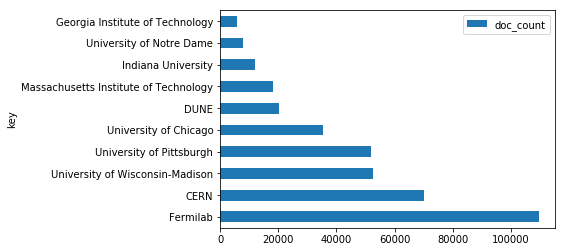

In [24]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, A

# https://gracc.opensciencegrid.org/q/gracc.osg.summary/_search

gracc=Elasticsearch('https://gracc.opensciencegrid.org/q',timeout=120)

# Last year
start='now-360d'
end='now'

# GRACC summary index
i='gracc.osg.summary'

search = Search(using=gracc, index=i).filter("range",EndTime={'gte':start,'lte':end})
count = search.count()

# Numero de elementos de la agregación.
print(count)

json_print(search.to_dict())

a = A('terms', field='OIM_Organization')
search.aggs.bucket('organization_terms', a)

t = search.execute()

# Normalizamos datos para pinter grafica.
from pandas.io.json import json_normalize
df = json_normalize(t.to_dict()['aggregations']['organization_terms']['buckets'])
df.head()


%matplotlib inline

df.plot.barh(x='key',y='doc_count')


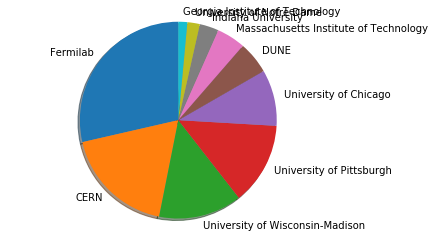

In [33]:
import matplotlib.pyplot as plt

organization_array = []
count_array = []
for vo in t.aggregations.organization_terms.buckets:
    organization_array.append(vo['key'])
    count_array.append(vo['doc_count'])

fig1, ax1 = plt.subplots()

ax1.pie(count_array, labels=organization_array, shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()